# Working with Hyperspy Data

In this notebook we will load a dataset with hyperspy and convert it to a sidpy dataset.

The sidpy dataset will enable you to use any package in the pycroscopy eco-system.

Using hyperspy may be especially usefull for utilization if its  io and/or anlysisis capabilities.


##  First we load the necessary packages

In [1]:
%pylab --no-import-all notebook
%gui qt

import sys

sys.path.insert(0, '../..')
import SciFiReaders

import hyperspy.api as hs
import pyTEMlib.file_tools as ft

print(SciFiReaders.__version__)

Populating the interactive namespace from numpy and matplotlib


AttributeError: module 'SciFiReaders.readers.converters' has no attribute '__all__'

## Select a file and load with hyperspy

We utilize here the open file dialog from pyTEMlib but this is not strictly necessary. Any convenient way to supply a filename will do.

The file will be loaded and plotted with hyperspy.

<IPython.core.display.Javascript object>


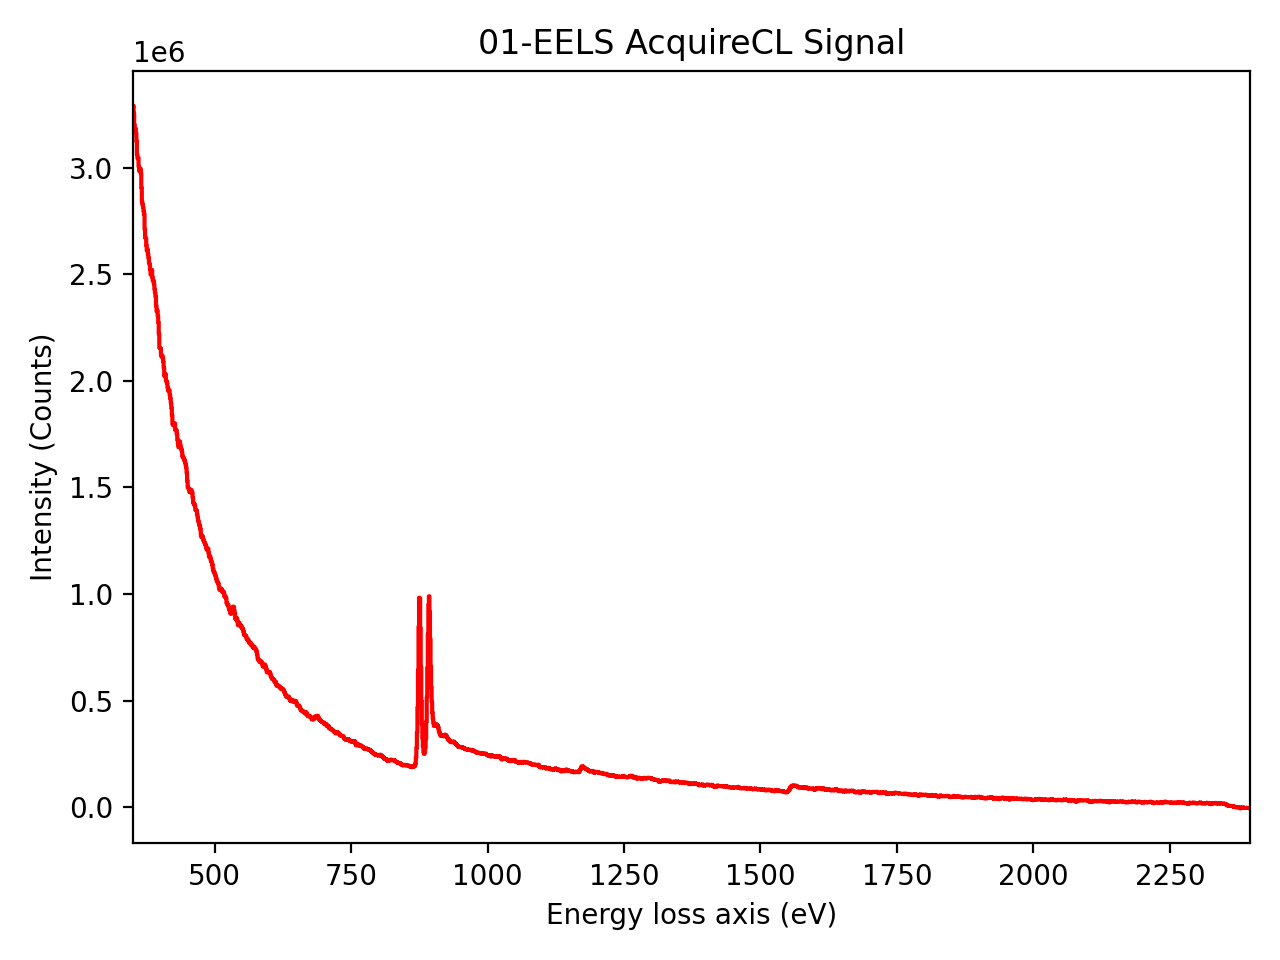

In [2]:
filename = ft.openfile_dialog()
s = hs.load(filename)
s.plot()

## Conversion to sipy
We convert the hyperspy object to a sidpy Dataset. To ensure that all information is retained some information is printed and the dataset is plotted

Acquisition_instrument : └── TEM
    ├── Detector
    │   └── EELS
    │       ├── collection_angle = 33.0
    │       ├── exposure = 50.0
    │       ├── frame_number = 50
    │       └── spectrometer = Enfinium ER NION
    ├── acquisition_mode = STEM
    ├── beam_current = 0.0
    ├── beam_energy = 200.0
    ├── camera_length = 2.8
    ├── convergence_angle = 30.0
    ├── magnification = 100.0
    └── microscope = Unknown

General : ├── date = 2021-05-01
├── original_filename = 01-EELS AcquireCL.dm3
├── time = 14:06:30
└── title = 01-EELS AcquireCL

Signal : ├── Noise_properties
│   └── Variance_linear_model
│       ├── gain_factor = 1.0
│       └── gain_offset = 0.0
├── binned = True
├── quantity = Intensity (Counts)
└── signal_type = EELS

sidpy.Dataset of type SPECTRUM with:
 dask.array<01, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: Intensity  (Counts)
 and Dimensions: 
Energy loss:  Energy loss (eV) of size (2048,)
 with metadata: ['

<IPython.core.display.Javascript object>


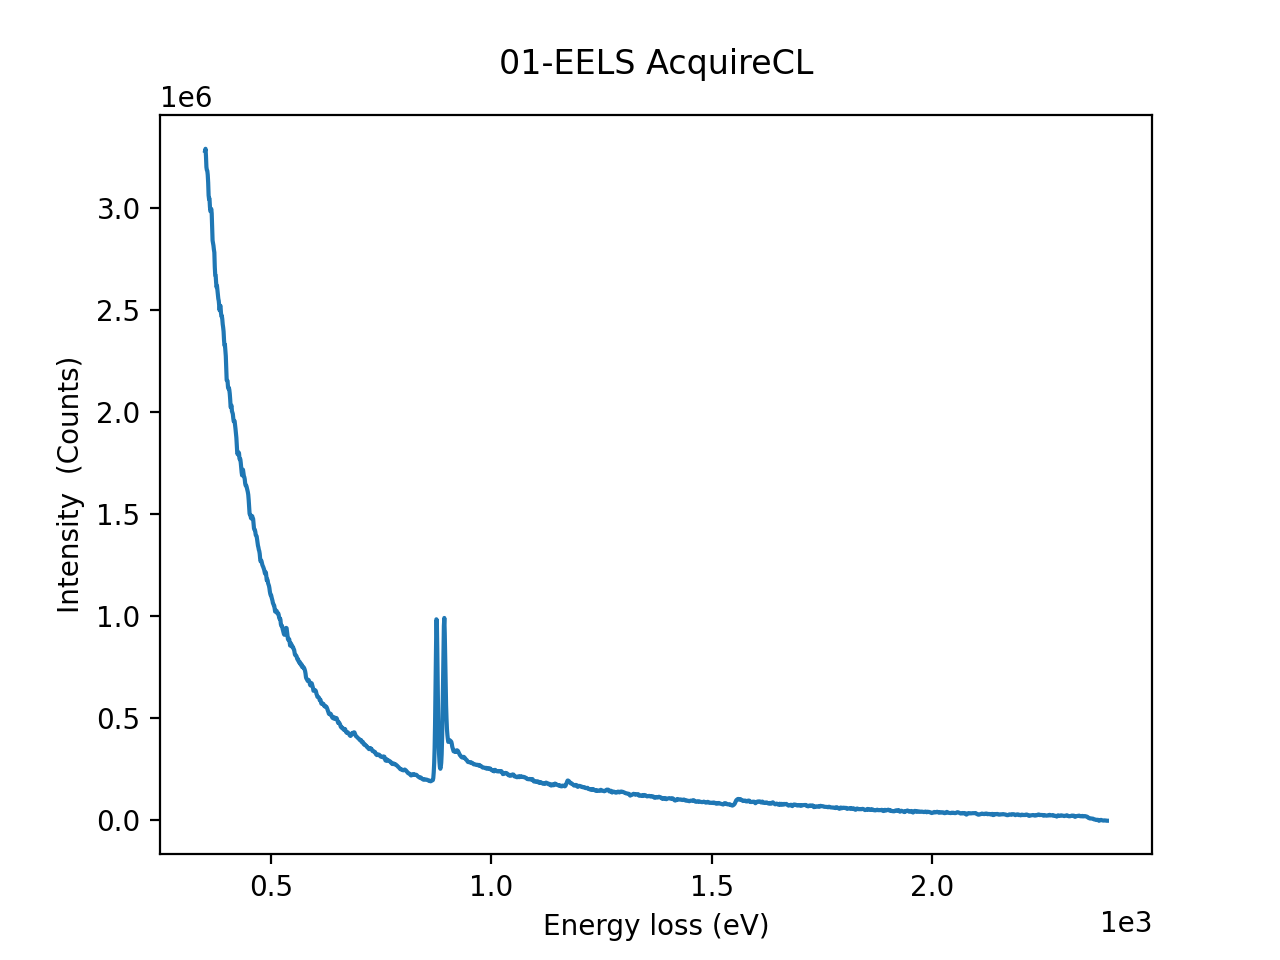

sidpy.Dataset of type SPECTRUM with:
 dask.array<01, shape=(2048,), dtype=float32, chunksize=(2048,), chunktype=numpy.ndarray>
 data contains: Intensity  (Counts)
 and Dimensions: 
Energy loss:  Energy loss (eV) of size (2048,)
 with metadata: ['Acquisition_instrument', 'General', 'Signal']

In [3]:
dataset = SciFiReaders.convert_hyperspy(s)

dataset.view_metadata()
print(dataset)
dataset.plot()
dataset

## Appendix
Code for conversion

In [ ]:
def convert_hyperspy(s):
    """ 
    Imports a hyperspy signal object into sidpy.Dataset
    
    Parameters
    ----------
    s: hyperspy dataset
    
    Return
    ------
    dataset: sidpy.Dataset
    """
    import hyperspy.api as hs

    if not isinstance(s, (hs.signals.Signal1D, hs.signals.Signal2D)):
        raise TypeError('This is not a hyperspy signal object')
    dataset = sidpy.Dataset.from_array(s, name=s.metadata.General.title)
    # Add dimension info
    axes = s.axes_manager.as_dictionary()

    if isinstance(s, hs.signals.Signal1D):
        if s.data.ndim < 2:
            dataset.data_type = 'spectrum'
        elif s._data.ndim > 1:
            if s.data.ndim  == 2:
                dataset = sidpy.Dataset.from_array(np.expand_dims(s,2), name=s.metadata.General.title)
                dataset.set_dimension(2,sidpy.Dimension([0], name='y' ,units='pixel', 
                                                        quantity='distance', dimension_type='spatial'))
            dataset.data_type = sidpy.DataType.SPECTRAL_IMAGE   
        for key, axis in axes.items():
            if axis['navigate']:
                dimension_type = 'spatial'
            else:
                dimension_type = 'spectral'
            dim_array = np.arange(axis['size'])* axis['scale']+axis['offset']
            if axis['units'] == '':
                axis['units'] = 'frame'
            dataset.set_dimension(int(key[-1]), sidpy.Dimension(dim_array, name=axis['name'] ,units=axis['units'], 
                                                                quantity=axis['name'], dimension_type=dimension_type))

    elif isinstance(s, hs.signals.Signal2D):
        if s.data.ndim < 4:
            if s.data.ndim == 2:
                dataset.data_type = 'image'
            elif s._data.ndim == 3:
                dataset.data_type = 'image_stack'
            for key, axis in axes.items():
                if axis['navigate']:
                    dimension_type = 'temporal'
                else:
                    dimension_type = 'spatial'
                dim_array = np.arange(axis['size'])* axis['scale']+axis['offset']
                if axis['units'] == '':
                    axis['units'] = 'pixel'
                dataset.set_dimension(int(key[-1]), sidpy.Dimension(dim_array, name=axis['name'] ,units=axis['units'], 
                                                                    quantity=axis['name'], dimension_type=dimension_type))                
        elif s.data.ndim == 4:
            dataset.data_type = 'IMAGE_4D'
            for key, axis in axes.items():
                if axis['navigate']:
                    dimension_type = 'spatial'
                else:
                    dimension_type = 'reciprocal'
                dim_array = np.arange(axis['size'])* axis['scale']+axis['offset']
                if axis['units'] == '':
                    axis['units'] = 'pixel'
                dataset.set_dimension(int(key[-1]), sidpy.Dimension(dim_array, name=axis['name'] ,units=axis['units'], 
                                                                    quantity=axis['name'], dimension_type=dimension_type))
    dataset.metadata = dict(s.metadata)
    dataset.original_metadata = dict(s.original_metadata)
    dataset.title = dataset.metadata['General']['title']
    dataset.units = dataset.metadata['Signal']['quantity '].split('(')[-1][:-1]
    dataset.quantity = dataset.metadata['Signal']['quantity '].split('(')[0]
    dataset.source = 'hyperspy'
    return dataset
